# Predicción de Mercados usando Tensorflow

### Import de librerías

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
from datetime import datetime

2023-05-15 11:53:25.360134: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-15 11:53:25.601184: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-15 11:53:25.602431: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-15 11:53:26.536692: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Import de los datos

In [2]:
data = pd.read_csv('./stocks/TSLA_5yr.csv')
print(data.shape)
print(data.sample(7))

data['Date'] = pd.to_datetime(data['Date'])

(1259, 7)
            Date        Open        High         Low       Close   Adj Close  \
711   2021-03-11  233.133331  234.166672  225.726669  233.199997  233.199997   
611   2020-10-15  150.103333  152.190002  147.500000  149.626663  149.626663   
451   2020-02-28   41.980000   46.034668   40.768002   44.532665   44.532665   
700   2021-02-24  237.283340  248.333328  231.389999  247.339996  247.339996   
122   2018-11-05   22.700001   22.930668   22.009333   22.760000   22.760000   
1055  2022-07-22  276.220001  280.786682  270.713318  272.243347  272.243347   
107   2018-10-15   17.270666   17.552000   16.969334   17.306000   17.306000   

         Volume  
711   108761700  
611   107017200  
451   363343500  
700   110301000  
122   117465000  
1055  103472700  
107    93000000  


### Mostramos las velas diarias

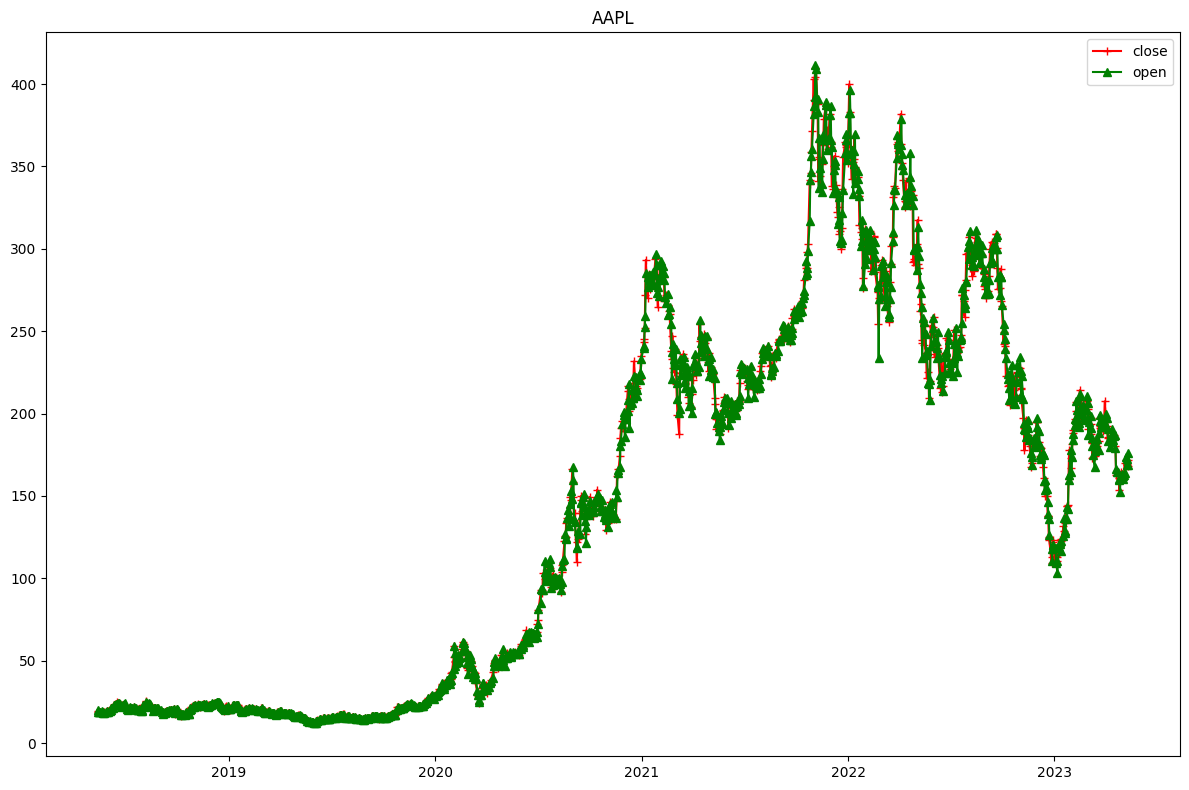

In [3]:
plt.figure(figsize=(12, 8))
plt.plot(data['Date'], data['Close'], c="r", label="close", marker="+")
plt.plot(data['Date'], data['Open'], c="g", label="open", marker="^")
plt.title("AAPL")
plt.legend()
plt.tight_layout()

### Mostramos el volumen diario

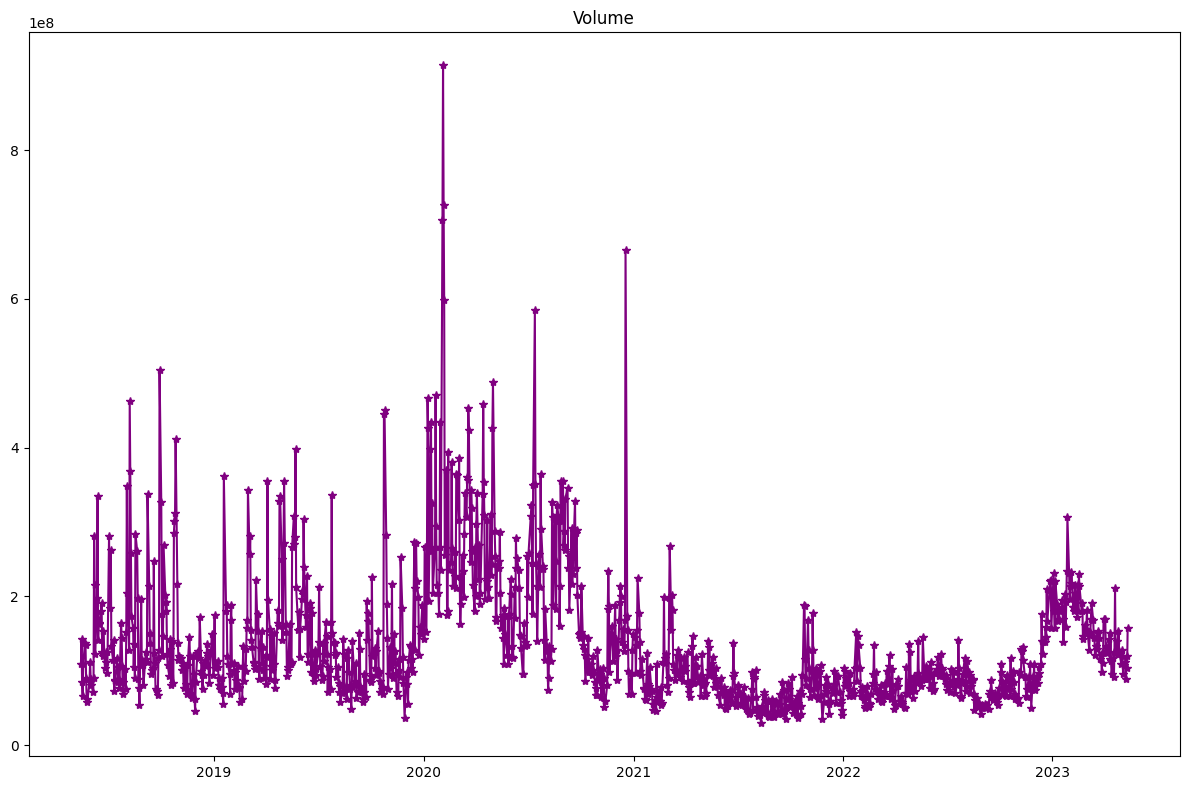

In [4]:
plt.figure(figsize=(12, 8))
plt.plot(data['Date'], data['Volume'], c='purple', marker='*')
plt.title("Volume")
plt.tight_layout()

### Mostramos los datos de entreno

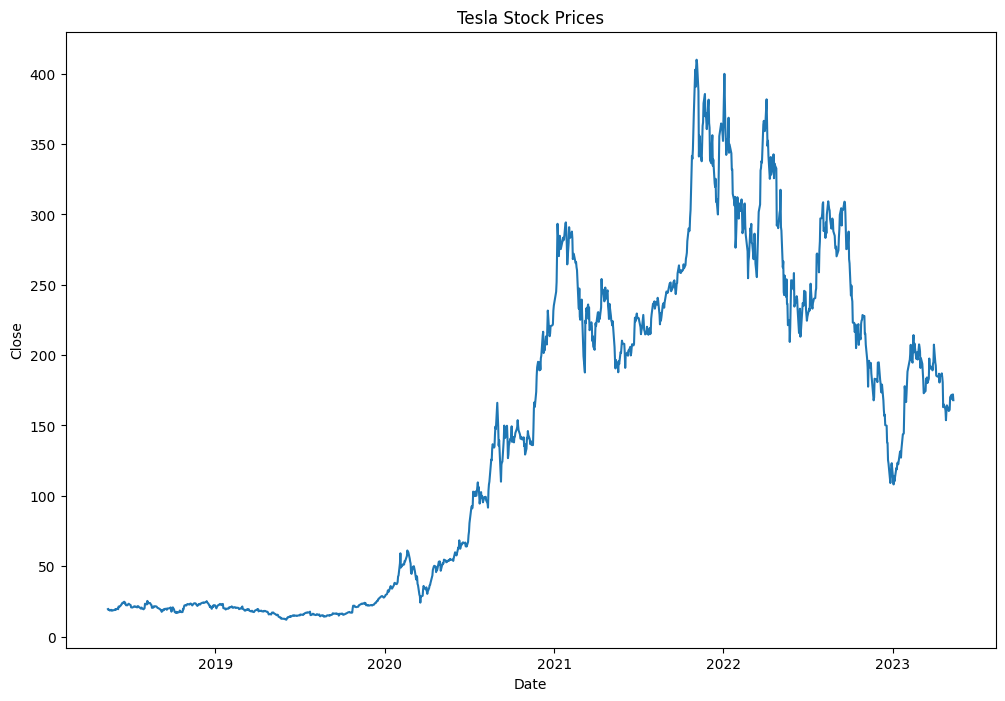

In [5]:
prediction_range = data.loc[(data['Date'] > datetime(2018,5,14)) & (data['Date'] < datetime(2023,5,14))]
plt.figure(figsize=(12, 8))
plt.plot(data['Date'], data['Close'])
plt.xlabel("Date")
plt.ylabel("Close")
plt.title("Tesla Stock Prices")
plt.show()

### Establecemos el set de entrenamiento y otro para la validación (95%/5%)

In [6]:
close_data = data.filter(['Close'])
dataset = close_data.values
training = int(np.ceil(len(dataset) * .95))
testing = int(np.floor(len(dataset) * .05))
print(training) 
print(testing)

1197
62


### Preparamos los datos para el entrenamiento

In [7]:
from sklearn.preprocessing import MinMaxScaler
  
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)
  
train_data = scaled_data[0:int(training), :]

x_train = []
y_train = []
  
for i in range(testing, len(train_data)):
    x_train.append(train_data[i - testing:i, 0])
    y_train.append(train_data[i, 0])
  
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

### Preparamos el modelo

In [13]:
model = keras.models.Sequential()
model.add(keras.layers.LSTM(units=64,
							return_sequences=True,
							input_shape=(x_train.shape[1], 1)))
model.add(keras.layers.LSTM(units=64))
model.add(keras.layers.Dense(32))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(1))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 62, 64)            16896     
                                                                 
 lstm_3 (LSTM)               (None, 64)                33024     
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 52,033
Trainable params: 52,033
Non-trainable params: 0
_________________________________________________________________


2023-05-15 11:53:53.036329: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-15 11:53:53.037479: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-15 11:53:53.038538: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

### Procedemos a entrenar el modelo

In [9]:
model.compile(optimizer='adam',
              loss='mean_squared_error')
history = model.fit(x_train,
                    y_train,
                    epochs=10)

Epoch 1/10


2023-05-15 11:53:29.679269: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-15 11:53:29.681142: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-15 11:53:29.682040: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

36/36 [==============================] - 4s 56ms/step - loss: 0.0323
Epoch 2/10
36/36 [==============================] - 2s 56ms/step - loss: 0.0106
Epoch 3/10
36/36 [==============================] - 2s 53ms/step - loss: 0.0088
Epoch 4/10
36/36 [==============================] - 2s 52ms/step - loss: 0.0081
Epoch 5/10
36/36 [==============================] - 2s 54ms/step - loss: 0.0082
Epoch 6/10
36/36 [==============================] - 2s 55ms/step - loss: 0.0091
Epoch 7/10
36/36 [==============================] - 2s 55ms/step - loss: 0.0070
Epoch 8/10
36/36 [==============================] - 2s 53ms/step - loss: 0.0070
Epoch 9/10
36/36 [==============================] - 2s 53ms/step - loss: 0.0071
Epoch 10/10
36/36 [==============================] - 2s 54ms/step - loss: 0.0070


### Establecemos los datos de prueba, generamos la predicción y los MSE

In [10]:
test_data = scaled_data[training - testing:, :]

x_test = []
y_test = dataset[training:, :]
for i in range(testing, len(test_data)):
    x_test.append(test_data[i-testing:i, 0])
  
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
  
# prediccion de los datos de prueba
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
  
# metricas MSE (Error Cuadrático Medio) y RMSE (Raiz del Error Cuadrático Medio)
mse = np.mean(((predictions - y_test) ** 2))
print("MSE", mse)
print("RMSE", np.sqrt(mse))

2023-05-15 11:53:51.394140: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-15 11:53:51.395881: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-15 11:53:51.397219: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2/2 [==============================] - 0s 20ms/step
MSE 114.42219399715637
RMSE 10.696831025923348


### Mostramos el resultado final con la predicción, entrenamiento y pruebas

/tmp/ipykernel_1437/1461219673.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = predictions


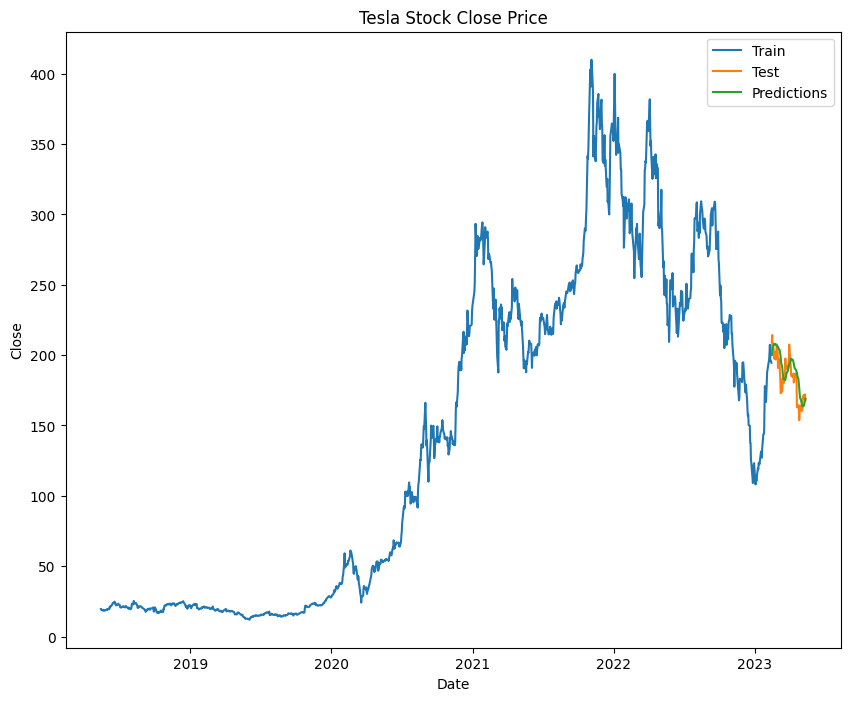

In [11]:
train = data[:training]
test = data[training:]
test['Predictions'] = predictions
  
plt.figure(figsize=(10, 8))
plt.plot(train['Date'], train['Close'])
plt.plot(test['Date'], test[['Close', 'Predictions']])
plt.title('Tesla Stock Close Price')
plt.xlabel('Date')
plt.ylabel("Close")
plt.legend(['Train', 'Test', 'Predictions'])
# plt.axis([2022,2023,120,180])

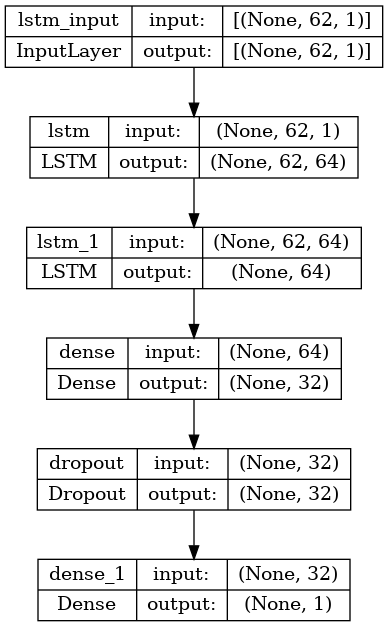

In [12]:
from keras.utils.vis_utils import plot_model

plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)
